In [476]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statistics as stats
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import clone 
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, accuracy_score,f1_score,precision_score, recall_score,roc_curve, roc_auc_score
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pylab as plt 
%matplotlib inline 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Breast Cancer patient survival prediction

- This project's goal is to use The Cancer Genome Atlas (TCGA) data on Breast cancer patients to predict the survival of patients from their condition and estimated survival time. This is a binary classification problem as the survival status can either be living or deceased. I hope to use supervised emsemble trees machine learning model for this problem.

- This project is important because breast cancer is one of the leading causes of cancer death in the world. By predict cancer patient survival from their clinical data given a projected survival time, we can know which patients are at higher risk of death. My machine learning model can be used to identify high risk breast cancer patients and suggest that the patients need more medical care. From my model, we can also understand which clinical features are important and affect patients' survival. My goal is to build a high performing model to predict breast cancer patient survival.

- The results here are in whole or part based upon data generated by the TCGA Research Network: https://www.cancer.gov/tcga. Data was downloaded using cBioPortal (citation below)

Cerami et al. The cBio Cancer Genomics Portal: An Open Platform for Exploring Multidimensional Cancer Genomics Data. Cancer Discovery. May 2012 2; 401. PubMed.


## Data import

The data is tabulated with 111 columns and 1097 different patients with breast cancer. The data is compiled by TCGA project and made publicly available.

The different columns include clinical information of patients (patient ID, Sex, Menopause status...). Due to the large number of columns, I will select a subset of relavant columns to our project.

- OS_MONTHS: (numerical) The overall survival time of patient in months from the diagnosis.
- OS_STATUS: (categorical) The survival status of patient after the overall survival time. It can either be living or deceased.
- SURGICAL_PROCEDURE_FIRST: (categorical) The first surgical procedure the patient have for cancer treatment
- ER_STATUS_BY_IHC: (categorical) breast cancer estrogen receptor status determined by Immunohistochemistry staining. This shows if the patient's tumor is responsive to the estrogen hormone.
- PR_STATUS_BY_IHC: (categorical) breast cancer progesterone receptor status determined by Immunohistochemistry staining. This shows if the patient's tumor is responsive to the progesterone hormone. This is another hormone used by hormone sensitive cancer.
- MENOPAUSE_STATUS:  (categorical) whether the patient has undergone menopause or not.
- RACE: (categorical) patient's racial group.
- HISTORY_OTHER_MALIGNANCY: (categorical) if the patients had a history of other type of cancers.
- AGE: (numerical) patient's age.
- PRIMARY_SITE_PATIENT: (categorical) where the tumor is located.
- AJCC_TUMOR_PATHOLOGIC_PT, AJCC_NODES_PATHOLOGIC_PN, AJCC_METASTASIS_PATHOLOGIC_PM,  AJCC_PATHOLOGIC_TUMOR_STAGE: American Joint Committee on Cancer Cancer (AJCC) Staging standards. This standard grades the primary tumor (PT), nodes (PN), and metatasis (PM). The higher the stage, the more advanced the tumor. The summary of 3 standard grades (PT, PN, PM) is Tumor Stage, ranging from 1 to 4.


In [421]:
df = pd.read_table("brca_tcga/data_clinical_patient.txt", delimiter="	")
df.shape

(1097, 111)

In [422]:
df.head()

,OTHER_PATIENT_ID,PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,MENOPAUSE_STATUS,RACE,ETHNICITY,HISTORY_OTHER_MALIGNANCY,...,METASTATIC_TUMOR_INDICATOR,PROJECT_CODE,PRIMARY_SITE_OTHER,STAGE_OTHER,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
0,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,1/13/14,NO,YES,Female,Pre (<6 months since LMP AND no prior bilatera...,WHITE,NOT HISPANIC OR LATINO,No,...,[Not Available],[Not Available],[Not Applicable],[Not Available],3C,Breast,0:LIVING,132.95,1:Recurred/Progressed,59.4
1,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,7/28/14,NO,YES,Female,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,[Not Available],[Not Available],[Not Applicable],[Not Available],3C,Breast,0:LIVING,131.57,0:DiseaseFree,131.57
2,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,7/28/14,NO,YES,Female,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,[Not Available],[Not Available],[Not Applicable],[Not Available],3C,Breast,0:LIVING,48.42,0:DiseaseFree,48.42
3,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,7/28/14,NO,YES,Female,[Not Available],BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,[Not Available],[Not Available],[Not Applicable],[Not Available],3C,Breast,0:LIVING,47.57,0:DiseaseFree,47.57
4,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,11/13/14,YES,NO,Female,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,No,...,[Not Available],[Not Available],[Not Applicable],[Not Available],4H,Breast,0:LIVING,11.43,0:DiseaseFree,11.43


## Data Cleaning

### Select relavant columns for the project

In [423]:
#Select columns
df=df[["OS_STATUS","OS_MONTHS","SURGICAL_PROCEDURE_FIRST","ER_STATUS_BY_IHC","PR_STATUS_BY_IHC","MENOPAUSE_STATUS","RACE",
            "HISTORY_OTHER_MALIGNANCY","AGE","AJCC_TUMOR_PATHOLOGIC_PT","AJCC_NODES_PATHOLOGIC_PN",
           "AJCC_METASTASIS_PATHOLOGIC_PM","AJCC_PATHOLOGIC_TUMOR_STAGE","PRIMARY_SITE_PATIENT"]]
df=df.replace("[Not Available]",None)
df.head()

,OS_STATUS,OS_MONTHS,SURGICAL_PROCEDURE_FIRST,ER_STATUS_BY_IHC,PR_STATUS_BY_IHC,MENOPAUSE_STATUS,RACE,HISTORY_OTHER_MALIGNANCY,AGE,AJCC_TUMOR_PATHOLOGIC_PT,AJCC_NODES_PATHOLOGIC_PN,AJCC_METASTASIS_PATHOLOGIC_PM,AJCC_PATHOLOGIC_TUMOR_STAGE,PRIMARY_SITE_PATIENT
0,0:LIVING,132.95,Modified Radical Mastectomy,Positive,Positive,Pre (<6 months since LMP AND no prior bilatera...,WHITE,No,55,TX,NX,MX,Stage X,Left Lower Outer Quadrant
1,0:LIVING,131.57,Lumpectomy,Positive,Positive,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,No,50,T2,N1a,M0,Stage IIB,Right Upper Outer Quadrant
2,0:LIVING,48.42,Modified Radical Mastectomy,Positive,Positive,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,No,62,T2,N1a,M0,Stage IIB,Right
3,0:LIVING,47.57,Simple Mastectomy,Positive,Positive,None,BLACK OR AFRICAN AMERICAN,No,52,T1c,N0 (i+),M0,Stage IA,Right
4,0:LIVING,11.43,Modified Radical Mastectomy,Positive,Positive,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,No,50,T2,N2a,M0,Stage IIIA,Left|Left Upper Outer Quadrant


In [424]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   OS_STATUS                      1097 non-null   object
 1   OS_MONTHS                      1096 non-null   object
 2   SURGICAL_PROCEDURE_FIRST       1043 non-null   object
 3   ER_STATUS_BY_IHC               1048 non-null   object
 4   PR_STATUS_BY_IHC               1047 non-null   object
 5   MENOPAUSE_STATUS               1007 non-null   object
 6   RACE                           1002 non-null   object
 7   HISTORY_OTHER_MALIGNANCY       1097 non-null   object
 8   AGE                            1096 non-null   object
 9   AJCC_TUMOR_PATHOLOGIC_PT       1097 non-null   object
 10  AJCC_NODES_PATHOLOGIC_PN       1097 non-null   object
 11  AJCC_METASTASIS_PATHOLOGIC_PM  1097 non-null   object
 12  AJCC_PATHOLOGIC_TUMOR_STAGE    1092 non-null   object
 13  PRI

### Inspect the number of missing observations in each columns

In [194]:
df.isnull().sum()

OS_STATUS                         0
OS_MONTHS                         1
SURGICAL_PROCEDURE_FIRST         54
ER_STATUS_BY_IHC                 49
PR_STATUS_BY_IHC                 50
MENOPAUSE_STATUS                 90
RACE                             95
HISTORY_OTHER_MALIGNANCY          0
AGE                               1
AJCC_TUMOR_PATHOLOGIC_PT          0
AJCC_NODES_PATHOLOGIC_PN          0
AJCC_METASTASIS_PATHOLOGIC_PM     0
AJCC_PATHOLOGIC_TUMOR_STAGE       5
PRIMARY_SITE_PATIENT              0
dtype: int64

We see that the number of missing observations are not high compared to the number of total observations. Therefore, I can impute the missing values.

### Inspect and clean each column

#### OS Status

Change the data type to binary by encoding living: 0 and deceased: 1

In [195]:
# OS_STATUS
print(df.OS_STATUS.unique())

labels = ['0:LIVING', '1:DECEASED']

df['OS_STATUS'] = df['OS_STATUS'].astype(pd.CategoricalDtype(categories=labels, ordered=True))
df['OS_STATUS'] = df['OS_STATUS'].cat.codes


['0:LIVING' '1:DECEASED']


#### OS months

Change the data type to float.
Impute the missing values with median value.

In [196]:
#OS_MONTHS
df.OS_MONTHS=df.OS_MONTHS.astype('float')

#Impute missing data as median
df.OS_MONTHS[df.OS_MONTHS.isnull()]=stats.median(df.OS_MONTHS)

/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/954768205.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.OS_MONTHS[df.OS_MONTHS.isnull()]=stats.median(df.OS_MONTHS)


#### Surgical procedure first

Change discrepancy values to missing.

Impute missing values with the most frequent categorical values.

In [197]:
#SURGICAL_PROCEDURE_FIRST
print(df.SURGICAL_PROCEDURE_FIRST.unique())

df.SURGICAL_PROCEDURE_FIRST[df.SURGICAL_PROCEDURE_FIRST=='[Discrepancy]']=None

# Impute missing data with the most frequent value
df.SURGICAL_PROCEDURE_FIRST[df.SURGICAL_PROCEDURE_FIRST.isnull()]=stats.mode(df.SURGICAL_PROCEDURE_FIRST)


['Modified Radical Mastectomy' 'Lumpectomy' 'Simple Mastectomy' None
 'Other' '[Discrepancy]']


/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/669428330.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.SURGICAL_PROCEDURE_FIRST[df.SURGICAL_PROCEDURE_FIRST=='[Discrepancy]']=None
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/669428330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.SURGICAL_PROCEDURE_FIRST[df.SURGICAL_PROCEDURE_FIRST.isnull()]=stats.mode(df.SURGICAL_PROCEDURE_FIRST)


#### ER Status

Impute missing values as the most common value.

Change the 3 levels to numerical values by encoding Negative=0, Intermediate=1, Positive =2.

In [198]:
# ER_STATUS_BY_IHC
df.ER_STATUS_BY_IHC[df.ER_STATUS_BY_IHC.isnull()]=stats.mode(df.ER_STATUS_BY_IHC)

labels = ['Negative', 'Indeterminate','Positive']

df['ER_STATUS_BY_IHC'] = df['ER_STATUS_BY_IHC'].astype(pd.CategoricalDtype(categories=labels, ordered=True))
df['ER_STATUS_BY_IHC'] = df['ER_STATUS_BY_IHC'].cat.codes

/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/2556623461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ER_STATUS_BY_IHC[df.ER_STATUS_BY_IHC.isnull()]=stats.mode(df.ER_STATUS_BY_IHC)


#### PR Status

Impute missing values as the most common value.

Change the 3 levels to numerical values by encoding Negative=0, Intermediate=1, Positive =2.

In [199]:
# PR_STATUS_BY_IHC
df.PR_STATUS_BY_IHC[df.PR_STATUS_BY_IHC.isnull()]=stats.mode(df.PR_STATUS_BY_IHC)

labels = ['Negative', 'Indeterminate','Positive']

df['PR_STATUS_BY_IHC'] = df['PR_STATUS_BY_IHC'].astype(pd.CategoricalDtype(categories=labels, ordered=True))
df['PR_STATUS_BY_IHC'] = df['PR_STATUS_BY_IHC'].cat.codes

/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/3870915134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PR_STATUS_BY_IHC[df.PR_STATUS_BY_IHC.isnull()]=stats.mode(df.PR_STATUS_BY_IHC)


#### Menopause Status

Impute missing values as the most common value.

Change the 3 levels to numerical values by encoding Pre menopause=0, Peri menopause=1, Post menopause =2.

In [200]:
# MENOPAUSE_STATUS
df.MENOPAUSE_STATUS[df.MENOPAUSE_STATUS.isnull()]=stats.mode(df.MENOPAUSE_STATUS)

df.MENOPAUSE_STATUS[df.MENOPAUSE_STATUS=='Indeterminate (neither Pre or Postmenopausal)']='Peri (6-12 months since last menstrual period)'

labels = ['Pre (<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement)','Peri (6-12 months since last menstrual period)', 
          'Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy)']

df['MENOPAUSE_STATUS'] = df['MENOPAUSE_STATUS'].astype(pd.CategoricalDtype(categories=labels, ordered=True))
df['MENOPAUSE_STATUS'] = df['MENOPAUSE_STATUS'].cat.codes



/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/1372229691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.MENOPAUSE_STATUS[df.MENOPAUSE_STATUS.isnull()]=stats.mode(df.MENOPAUSE_STATUS)
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/1372229691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.MENOPAUSE_STATUS[df.MENOPAUSE_STATUS=='Indeterminate (neither Pre or Postmenopausal)']='Peri (6-12 months since last menstrual period)'


#### Race

Impute missing values as the most common value.

Because the number of observations for races other than White and Black are low, I group all races other than black and white to other. This helps simplify the data.

In [201]:
#RACE
df.RACE[df.RACE.isnull()]=stats.mode(df.RACE)

df.RACE[df.RACE=='ASIAN']='OTHER'
df.RACE[df.RACE=='AMERICAN INDIAN OR ALASKA NATIVE']='OTHER'


/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/1727428216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.RACE[df.RACE.isnull()]=stats.mode(df.RACE)
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/1727428216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.RACE[df.RACE=='ASIAN']='OTHER'
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/1727428216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

#### History of other malignancy
Impute missing values as the most common value

Change data type to binary by encoding No=0 and Yes=1

In [202]:
# HISTORY_OTHER_MALIGNANCY
df.HISTORY_OTHER_MALIGNANCY[df.HISTORY_OTHER_MALIGNANCY=='[Discrepancy]']=stats.mode(df.HISTORY_OTHER_MALIGNANCY)

labels = ['No', 'Yes']

df['HISTORY_OTHER_MALIGNANCY'] = df['HISTORY_OTHER_MALIGNANCY'].astype(pd.CategoricalDtype(categories=labels, ordered=True))
df['HISTORY_OTHER_MALIGNANCY'] = df['HISTORY_OTHER_MALIGNANCY'].cat.codes


/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/3432210102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.HISTORY_OTHER_MALIGNANCY[df.HISTORY_OTHER_MALIGNANCY=='[Discrepancy]']=stats.mode(df.HISTORY_OTHER_MALIGNANCY)


#### Age
Change data type to float.

Impute the missing values as the median value.

In [203]:
# AGE
df.AGE=df.AGE.astype('float')

#Impute missing data as median
df.AGE[df.AGE.isnull()]=stats.median(df.AGE)

/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/2423431559.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AGE[df.AGE.isnull()]=stats.median(df.AGE)


#### Primary Tumor stage
To simplify the column, I will change all substages to the main stages, so that the variables are 1,2,3, or 4. 

Stage X means the tumor can't be evaluated, so I treat it as missing values.
Impute missing values as the most common value.

Change the data type to numerical with stages ranked from low to high.

In [204]:
# AJCC_TUMOR_PATHOLOGIC_PT
df.AJCC_TUMOR_PATHOLOGIC_PT[[i in ["T1","T1a","T1b","T1c"] for i in df.AJCC_TUMOR_PATHOLOGIC_PT]]="T1"
df.AJCC_TUMOR_PATHOLOGIC_PT[[i in ["T2","T2a","T2b","T2c"] for i in df.AJCC_TUMOR_PATHOLOGIC_PT]]="T2"
df.AJCC_TUMOR_PATHOLOGIC_PT[[i in ["T3","T3a","T3b","T3c"] for i in df.AJCC_TUMOR_PATHOLOGIC_PT]]="T3"
df.AJCC_TUMOR_PATHOLOGIC_PT[[i in ["T4","T4a","T4b","T4c","T4d"] for i in df.AJCC_TUMOR_PATHOLOGIC_PT]]="T4"

df.AJCC_TUMOR_PATHOLOGIC_PT[df.AJCC_TUMOR_PATHOLOGIC_PT=="TX"]=stats.mode(df.AJCC_TUMOR_PATHOLOGIC_PT)

df['AJCC_TUMOR_PATHOLOGIC_PT'] = df['AJCC_TUMOR_PATHOLOGIC_PT'].astype(pd.CategoricalDtype(categories=sorted(df['AJCC_TUMOR_PATHOLOGIC_PT'].unique()), ordered=True))
df['AJCC_TUMOR_PATHOLOGIC_PT'] = df['AJCC_TUMOR_PATHOLOGIC_PT'].cat.codes


/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/376188319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_TUMOR_PATHOLOGIC_PT[[i in ["T1","T1a","T1b","T1c"] for i in df.AJCC_TUMOR_PATHOLOGIC_PT]]="T1"
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/376188319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_TUMOR_PATHOLOGIC_PT[[i in ["T2","T2a","T2b","T2c"] for i in df.AJCC_TUMOR_PATHOLOGIC_PT]]="T2"
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/376188319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

#### Nodes stage
To simplify the column, I will change all substages to the main stages, so that the variables are 1,2, or 3. 

Stage X means the tumor can't be evaluated, so I treat it as missing values.

Impute missing values as the most common value.

Change the data type to numerical with stages ranked from low to high.

In [205]:
# AJCC_NODES_PATHOLOGIC_PN
df.AJCC_NODES_PATHOLOGIC_PN[[i in ["N0","N0 (i-)","N0 (i+)","N0 (mol+)"] for i in df.AJCC_NODES_PATHOLOGIC_PN]]="N0"
df.AJCC_NODES_PATHOLOGIC_PN[[i in ["N1","N1a","N1mi","N1b","N1c"] for i in df.AJCC_NODES_PATHOLOGIC_PN]]="N1"
df.AJCC_NODES_PATHOLOGIC_PN[[i in ["N2","N2a"] for i in df.AJCC_NODES_PATHOLOGIC_PN]]="N2"
df.AJCC_NODES_PATHOLOGIC_PN[[i in ["N3","N3a","N3b","N3c"] for i in df.AJCC_NODES_PATHOLOGIC_PN]]="N3"

df.AJCC_NODES_PATHOLOGIC_PN[df.AJCC_NODES_PATHOLOGIC_PN=="NX"]=stats.mode(df.AJCC_NODES_PATHOLOGIC_PN)

df['AJCC_NODES_PATHOLOGIC_PN'] = df['AJCC_NODES_PATHOLOGIC_PN'].astype(pd.CategoricalDtype(categories=sorted(df['AJCC_NODES_PATHOLOGIC_PN'].unique()), ordered=True))
df['AJCC_NODES_PATHOLOGIC_PN'] = df['AJCC_NODES_PATHOLOGIC_PN'].cat.codes


/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/2350607142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_NODES_PATHOLOGIC_PN[[i in ["N0","N0 (i-)","N0 (i+)","N0 (mol+)"] for i in df.AJCC_NODES_PATHOLOGIC_PN]]="N0"
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/2350607142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_NODES_PATHOLOGIC_PN[[i in ["N1","N1a","N1mi","N1b","N1c"] for i in df.AJCC_NODES_PATHOLOGIC_PN]]="N1"
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/2350607142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

#### Metastasis stage
To simplify the column, I will change all substages to the main stages, so that the variables are 0 or 1. 

Stage X means the tumor can't be evaluated, so I treat it as missing values.

Impute missing values as the most common value.

Change the data type to binary by encoding stage 0 = 0 and stage 1 = 1.

In [206]:
# AJCC_METASTASIS_PATHOLOGIC_PM
df.AJCC_METASTASIS_PATHOLOGIC_PM[[i in ["M0","cM0 (i+)"] for i in df.AJCC_METASTASIS_PATHOLOGIC_PM]]="M0"

df.AJCC_METASTASIS_PATHOLOGIC_PM[df.AJCC_METASTASIS_PATHOLOGIC_PM=="MX"]=stats.mode(df.AJCC_METASTASIS_PATHOLOGIC_PM)

df['AJCC_METASTASIS_PATHOLOGIC_PM'] = df['AJCC_METASTASIS_PATHOLOGIC_PM'].astype(pd.CategoricalDtype(categories=sorted(df['AJCC_METASTASIS_PATHOLOGIC_PM'].unique()), ordered=True))
df['AJCC_METASTASIS_PATHOLOGIC_PM'] = df['AJCC_METASTASIS_PATHOLOGIC_PM'].cat.codes


/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/654612413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_METASTASIS_PATHOLOGIC_PM[[i in ["M0","cM0 (i+)"] for i in df.AJCC_METASTASIS_PATHOLOGIC_PM]]="M0"
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/654612413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_METASTASIS_PATHOLOGIC_PM[df.AJCC_METASTASIS_PATHOLOGIC_PM=="MX"]=stats.mode(df.AJCC_METASTASIS_PATHOLOGIC_PM)


#### Overall Tumor stage

To simplify the column, I will change all substages to the main stages, so that the variables are 1,2,3, or 4. 

Stage X means the tumor can't be evaluated, so I treat it as missing values.

Impute missing values as the most common value.

Change the data type to numerical with stages ranked from low to high.

In [207]:
# AJCC_PATHOLOGIC_TUMOR_STAGE
df.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["Stage I","Stage IA","Stage IB","Stage IC"] for i in df.AJCC_PATHOLOGIC_TUMOR_STAGE]]="1"
df.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["Stage II","Stage IIA","Stage IIB","Stage IIC"] for i in df.AJCC_PATHOLOGIC_TUMOR_STAGE]]="2"
df.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["Stage III","Stage IIIA","Stage IIIB","Stage IIIC"] for i in df.AJCC_PATHOLOGIC_TUMOR_STAGE]]="3"
df.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["Stage IV","Stage IV","Stage IV","Stage IV"] for i in df.AJCC_PATHOLOGIC_TUMOR_STAGE]]="4"

df.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["[Discrepancy]","Stage X",None] for i in df.AJCC_PATHOLOGIC_TUMOR_STAGE]]=stats.mode(df.AJCC_PATHOLOGIC_TUMOR_STAGE)

df['AJCC_PATHOLOGIC_TUMOR_STAGE'] = df['AJCC_PATHOLOGIC_TUMOR_STAGE'].astype(pd.CategoricalDtype(categories=sorted(df['AJCC_PATHOLOGIC_TUMOR_STAGE'].unique()), ordered=True))
df['AJCC_PATHOLOGIC_TUMOR_STAGE'] = df['AJCC_PATHOLOGIC_TUMOR_STAGE'].cat.codes


/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/3819197501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["Stage I","Stage IA","Stage IB","Stage IC"] for i in df.AJCC_PATHOLOGIC_TUMOR_STAGE]]="1"
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/3819197501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["Stage II","Stage IIA","Stage IIB","Stage IIC"] for i in df.AJCC_PATHOLOGIC_TUMOR_STAGE]]="2"
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/3819197501.py:4: SettingWithCopyWarning: 
A v

#### Primary tumor site

There are 4 main sites for Breast cancer: Lower Inner, Upper Inner, Lower Outer, and Upper Outer Quadrant.

I see that some of the tumors can be overlapping in multiple quadrant. I will rename them as Overlapping.

Some tumors' quadrants are not specified so I treat them as missing.

Impute missing values as the most common value.

In [208]:
# PRIMARY_SITE_PATIENT
for i in range(len(df.PRIMARY_SITE_PATIENT)):
    site=[]
    if "Lower Inner" in df.PRIMARY_SITE_PATIENT[i]:
        site.append("Lower Inner")
    if "Upper Inner" in df.PRIMARY_SITE_PATIENT[i]:
        site.append("Upper Inner")
    if "Lower Outer" in df.PRIMARY_SITE_PATIENT[i]:
        site.append("Lower Outer")
    if "Upper Outer" in df.PRIMARY_SITE_PATIENT[i]:
        site.append("Upper Outer")
    if len(site)==1:
        x=site[0]
    elif len(site)>1:
        x="Overlapping"
    else:
        x=None
    df.PRIMARY_SITE_PATIENT[i]=x
    
df.PRIMARY_SITE_PATIENT[df.PRIMARY_SITE_PATIENT.isnull()]=stats.mode(df.PRIMARY_SITE_PATIENT)



/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/4163994060.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PRIMARY_SITE_PATIENT[i]=x
/var/folders/by/5_86hkts6lxdnygbd90mtb7h0000gn/T/ipykernel_65284/4163994060.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PRIMARY_SITE_PATIENT[df.PRIMARY_SITE_PATIENT.isnull()]=stats.mode(df.PRIMARY_SITE_PATIENT)


Double checking the data type of each column. We see that the columns are in the correct data type.

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OS_STATUS                      1097 non-null   int8   
 1   OS_MONTHS                      1097 non-null   float64
 2   SURGICAL_PROCEDURE_FIRST       1097 non-null   object 
 3   ER_STATUS_BY_IHC               1097 non-null   int8   
 4   PR_STATUS_BY_IHC               1097 non-null   int8   
 5   MENOPAUSE_STATUS               1097 non-null   int8   
 6   RACE                           1097 non-null   object 
 7   HISTORY_OTHER_MALIGNANCY       1097 non-null   int8   
 8   AGE                            1097 non-null   float64
 9   AJCC_TUMOR_PATHOLOGIC_PT       1097 non-null   int8   
 10  AJCC_NODES_PATHOLOGIC_PN       1097 non-null   int8   
 11  AJCC_METASTASIS_PATHOLOGIC_PM  1097 non-null   int8   
 12  AJCC_PATHOLOGIC_TUMOR_STAGE    1097 non-null   i

## Exploratory Data Analysis

### Visualization of numerical features

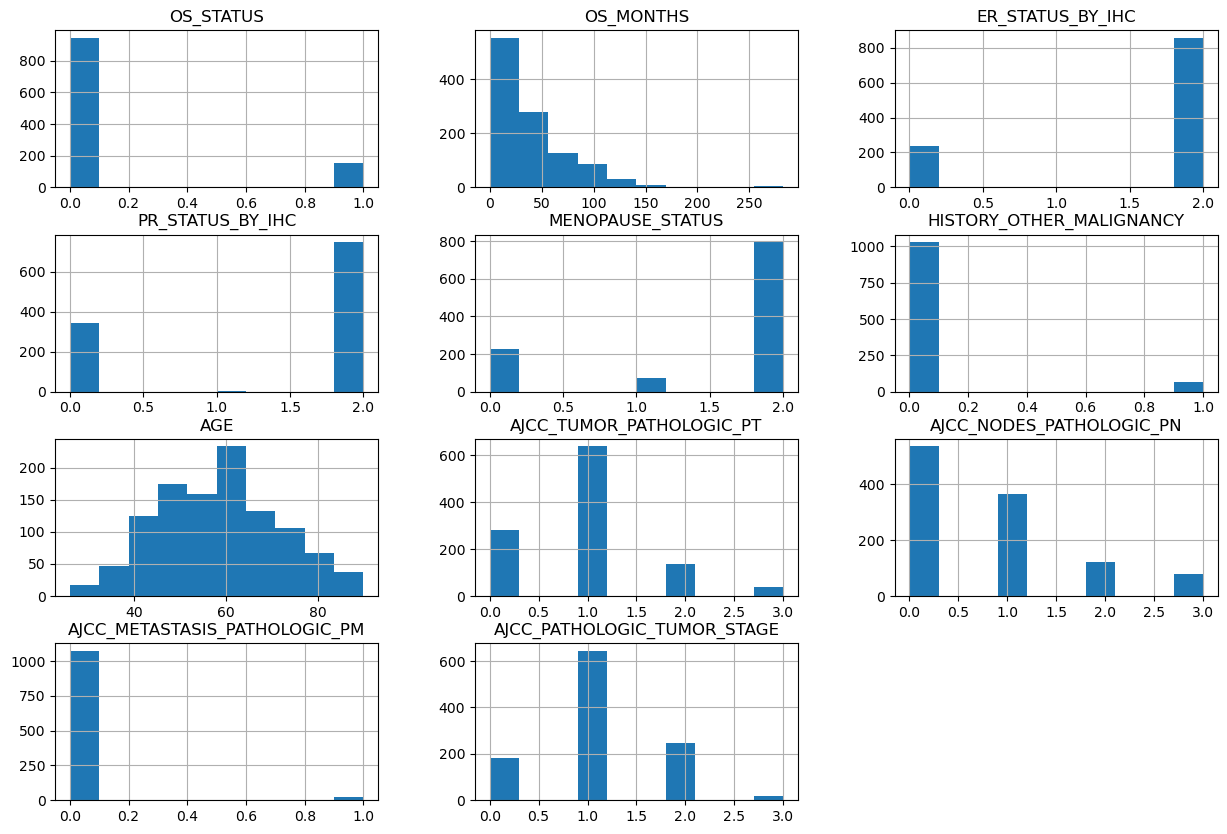

In [214]:
hists = df.hist(figsize=(15,10))
plt.show()

### Visualization of categorical columns

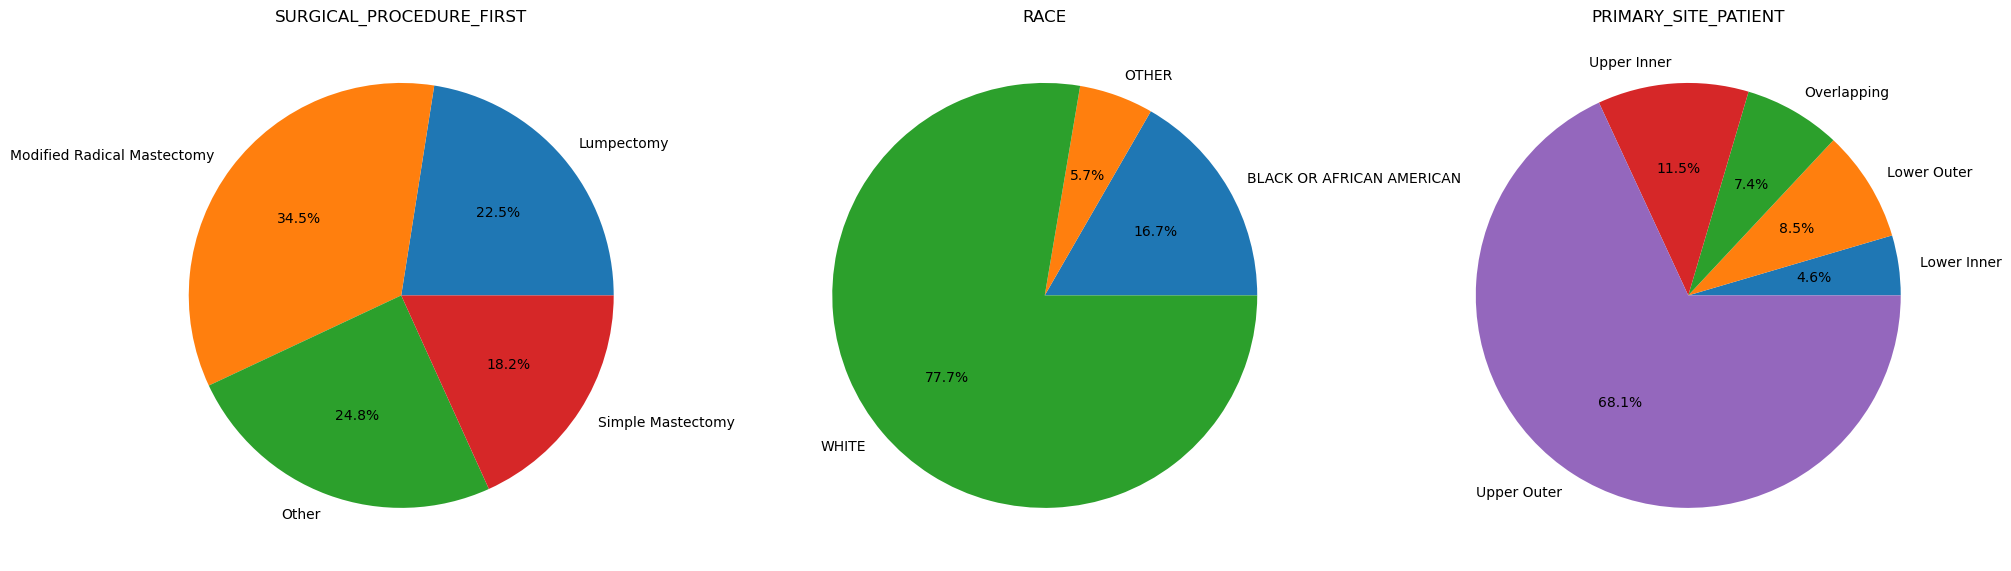

In [220]:

cat_col=["SURGICAL_PROCEDURE_FIRST","RACE","PRIMARY_SITE_PATIENT"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), cat_col):
    t = df.groupby([column]).size()
    ax.pie(t, labels=t.index.values, autopct='%1.1f%%')
    ax.set_title(column)

plt.show()

### Process categorical features

Split categorical features into multiple binary columns for each group using pd.get_dummies.

In [224]:
# Process Categorical features
df_processed=pd.get_dummies(df)
df_processed.head()

,OS_STATUS,OS_MONTHS,ER_STATUS_BY_IHC,PR_STATUS_BY_IHC,MENOPAUSE_STATUS,HISTORY_OTHER_MALIGNANCY,AGE,AJCC_TUMOR_PATHOLOGIC_PT,AJCC_NODES_PATHOLOGIC_PN,AJCC_METASTASIS_PATHOLOGIC_PM,...,SURGICAL_PROCEDURE_FIRST_Other,SURGICAL_PROCEDURE_FIRST_Simple Mastectomy,RACE_BLACK OR AFRICAN AMERICAN,RACE_OTHER,RACE_WHITE,PRIMARY_SITE_PATIENT_Lower Inner,PRIMARY_SITE_PATIENT_Lower Outer,PRIMARY_SITE_PATIENT_Overlapping,PRIMARY_SITE_PATIENT_Upper Inner,PRIMARY_SITE_PATIENT_Upper Outer
0,0,132.95,2,2,0,0,55.0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,131.57,2,2,2,0,50.0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,0,48.42,2,2,2,0,62.0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
3,0,47.57,2,2,2,0,52.0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
4,0,11.43,2,2,2,0,50.0,1,2,0,...,0,0,0,0,1,0,0,0,0,1


### Correlation Matrix

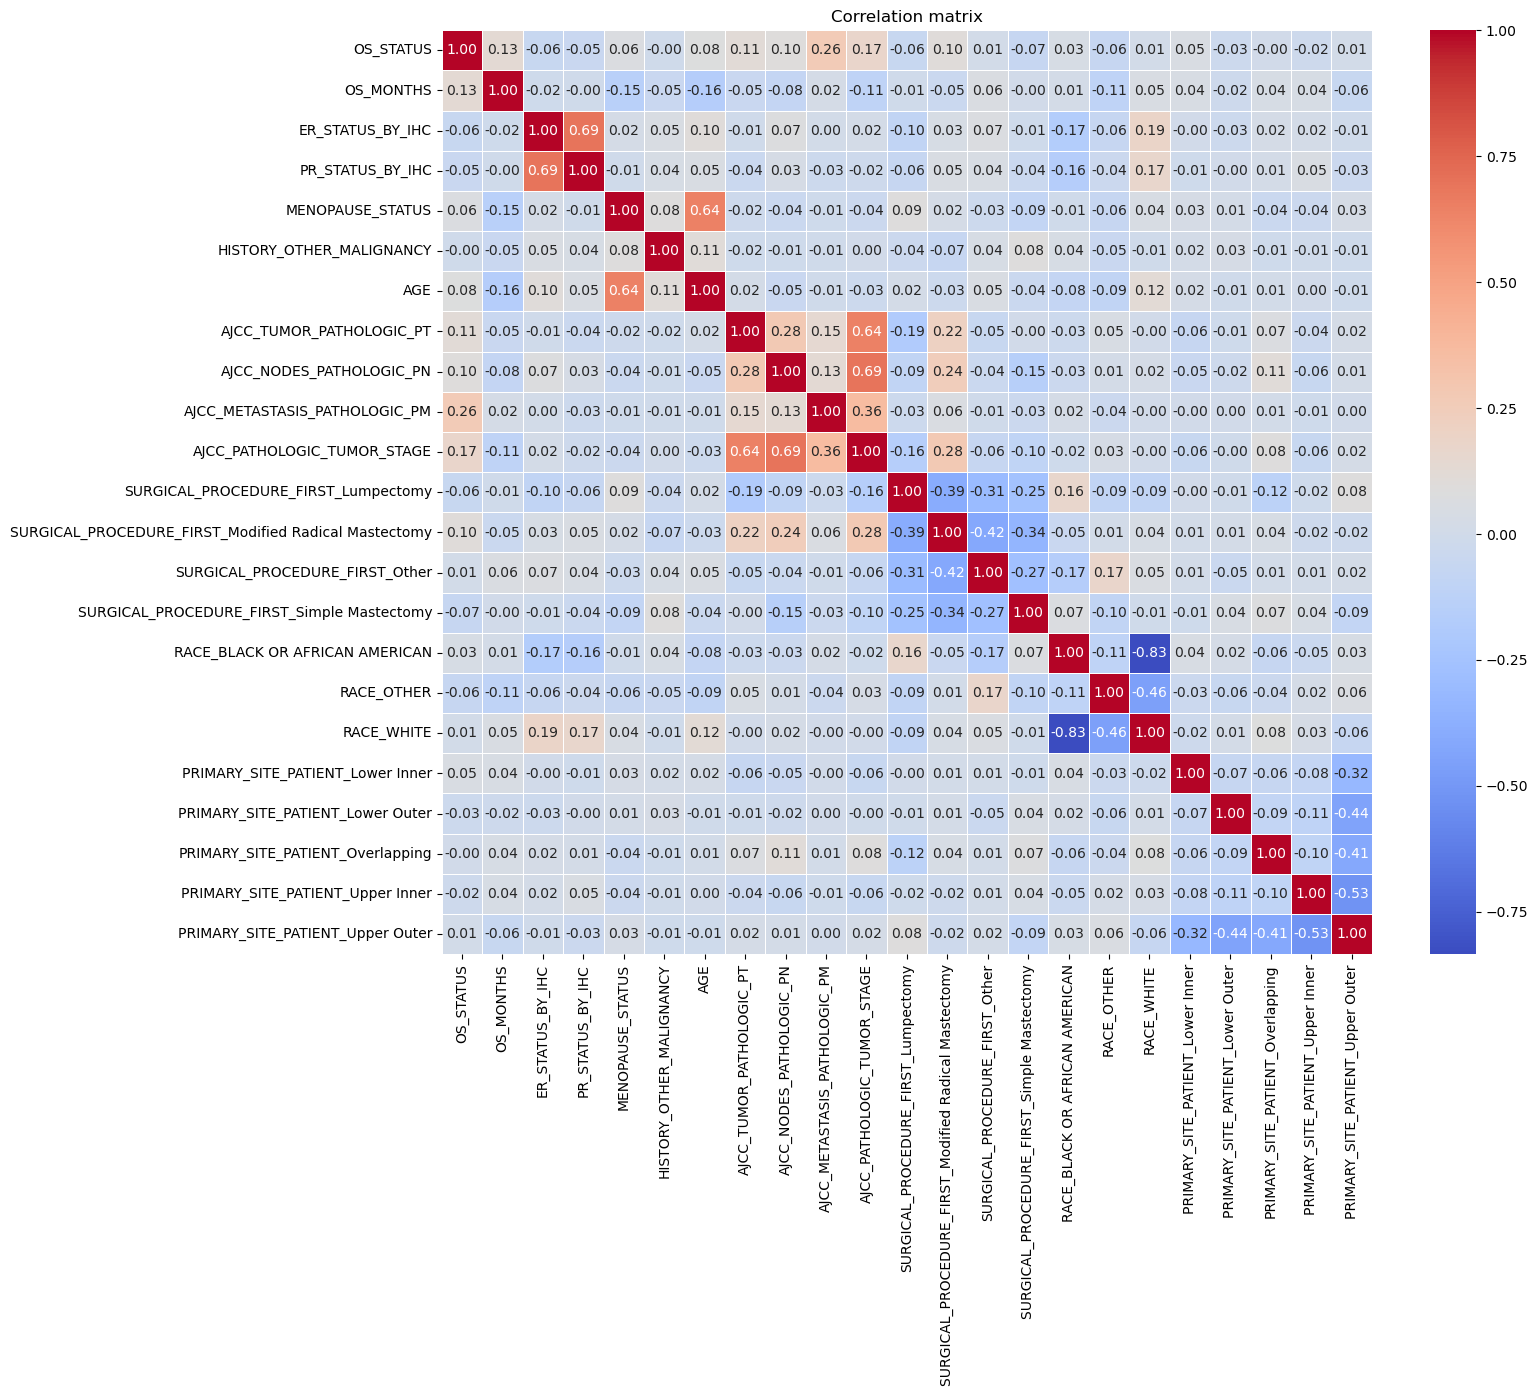

In [227]:
# Building a correlation matrix
corr_mat = df_processed.corr()

# Building a heat map of the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix')
plt.show()

#### Discussion

- Based on the correlation matrix, I see that the our response variable, OS Status, is positively correlated with metastasis status, tumor stage, survival month, stage of primary tumor. These features are important in predicting patient survival. This is because patients with more advanced and metastasized tumor usually have lower rate of survival. OS status correlates with OS month because patients with longer time from diagnosis usually have more chances of death. 

- OS status also has a positive correlation with first surgical procedure as Modified Radical Mastectomy. This might unveal an interesting relationship between surgical procedure and survival. 

- OS status has a negative correlation with ER and PR status. This might suggest that hormone sensitive breast cancer patients can have a better chance of survival because of the available hormone therapy. 

- Inspecting other features, I notice some high correlation between features. ER and PR status have a strong positive correlation because patients sensitive to hormone usually are sensitive to both ER and PR.

- Age and menopause status have a strong positive correlation because women often go through menopause after a certain age.

- The primary tumor, nodes, and metastasis stage are correlated with overall tumor stage because they are the 3 components to decide the overall tumor stage.

- I will pay attention to these correlation and do further inspection to avoid collinearity before fitting the data. Overall, the correlations in data make sense.

### Statistical tests

From the correlation matrix, I will perform statistical tests on some features of different OS status. This will help me gain more insights into the features.

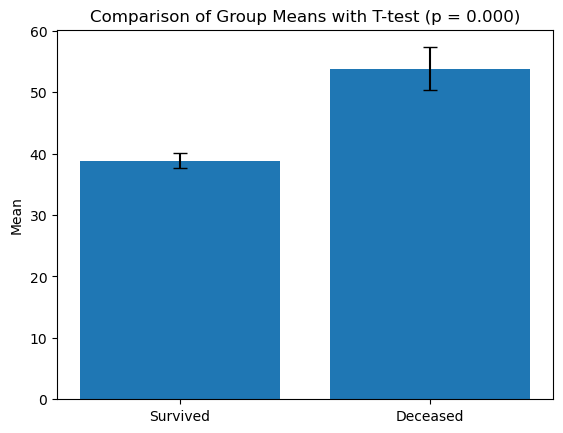

In [431]:
#OS months
Survived = np.array(df_processed[df_processed.OS_STATUS==0].OS_MONTHS)
Deceased = np.array(df_processed[df_processed.OS_STATUS==1].OS_MONTHS)
t_statistic, p_value = ss.ttest_ind(Survived, Deceased)

means = [np.mean(Survived), np.mean(Deceased)]
errors = [ss.sem(Survived), ss.sem(Deceased)]

plt.bar(["Survived", "Deceased"], means, yerr=errors, capsize=5)
plt.ylabel("Mean")
plt.title("Comparison of Group Means with T-test (p = {:.3f})".format(p_value))
plt.show()

I performed 2 sample t-test comparing the survival months of the living and deceased groups.

The t-test shows significant difference in the survival months (p<0.05) with the deceased group having larger survival months. This is consistent with the correlation matrix and suggests that patients have a higher chance of death when you have gone through a long time since cancer diagnosis.

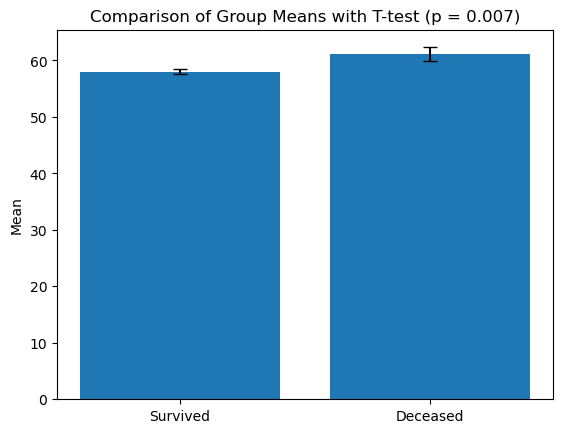

In [432]:
# Age
Survived = np.array(df_processed[df_processed.OS_STATUS==0].AGE)
Deceased = np.array(df_processed[df_processed.OS_STATUS==1].AGE)
t_statistic, p_value = ss.ttest_ind(Survived, Deceased)

means = [np.mean(Survived), np.mean(Deceased)]
errors = [ss.sem(Survived), ss.sem(Deceased)]

plt.bar(["Survived", "Deceased"], means, yerr=errors, capsize=5)
plt.ylabel("Mean")
plt.title("Comparison of Group Means with T-test (p = {:.3f})".format(p_value))
plt.show()

I performed 2 sample t-test comparing the age of the living and deceased groups.

The t-test shows significant difference in the age (p<0.05) with the deceased group being older. This is consistent with the correlation matrix and suggests that older patients have a higher chance of death.

Chi-Square: 70.31804864470608
P-value: 5.04737790112732e-17
Degrees of freedom: 1
Expected frequencies: [[926.04831358 148.95168642]
 [ 18.95168642   3.04831358]]


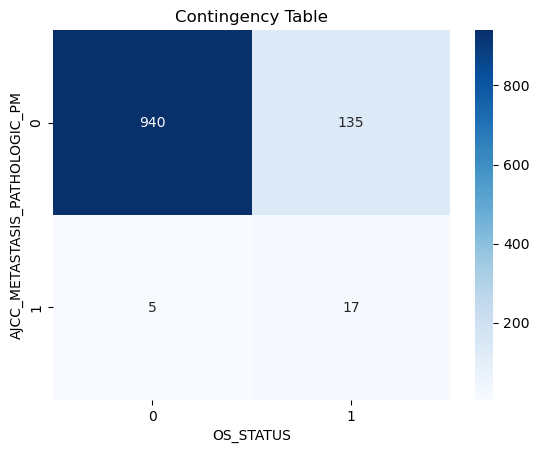

In [437]:
# Metastasis status
contingency_table=pd.crosstab(df_processed['AJCC_METASTASIS_PATHOLOGIC_PM'], df_processed['OS_STATUS'])
chi2, p, dof, expected = ss.chi2_contingency(contingency_table)

print("Chi-Square:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)


sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title("Contingency Table")
plt.show()

I performed chi-squared test for metastasis status and OS status. The chi-squared test showed a significant difference between the expected and observed distribution of metastasis status. 

This suggests that the number of patient having metastasized tumors is higher than expected in the deceased group, which means metastasized patients are more likely to be dead.

Chi-Square: 9.916446167492994
P-value: 0.0016380837323400818
Degrees of freedom: 1
Expected frequencies: [[619.37556974  99.62443026]
 [325.62443026  52.37556974]]


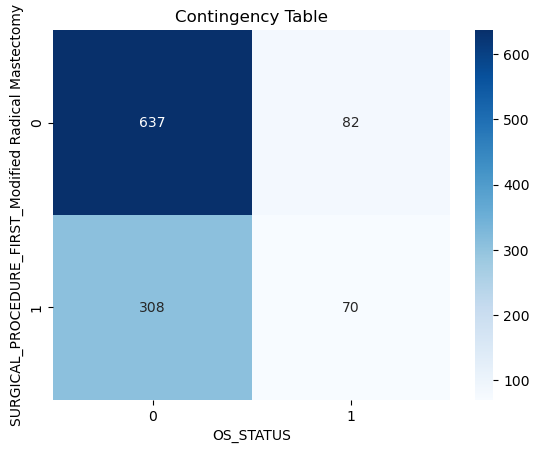

In [440]:
# Modified Radical Mastectomy
contingency_table=pd.crosstab(df_processed['SURGICAL_PROCEDURE_FIRST_Modified Radical Mastectomy'], df_processed['OS_STATUS'])
chi2, p, dof, expected = ss.chi2_contingency(contingency_table)

print("Chi-Square:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)


sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title("Contingency Table")
plt.show()

I performed chi-squared test for First surgical procedure as modified radical mastectomy and OS status. The chi-squared test showed a significant difference between the expected and observed distribution of this procedure. 

This suggests that the number of patient having this procedure as their first surgical procedure is higher than expected in the deceased group, which means these patients are more likely to be dead.

## Models

### Collinearity

I will detect collinearity in my data set using Variance Inflation Factor(VIF). I noticed before that there are some correlation between features, but they are not strong correlations.

In [229]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_processed.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_processed.values, i)
                          for i in range(len(df_processed.columns))]

print(vif_data)

                                              feature       VIF
0                                           OS_STATUS  1.142234
1                                           OS_MONTHS  1.108246
2                                    ER_STATUS_BY_IHC  2.004355
3                                    PR_STATUS_BY_IHC  1.963061
4                                    MENOPAUSE_STATUS  1.766709
5                            HISTORY_OTHER_MALIGNANCY  1.035331
6                                                 AGE  1.817892
7                            AJCC_TUMOR_PATHOLOGIC_PT  1.988983
8                            AJCC_NODES_PATHOLOGIC_PN  2.288609
9                       AJCC_METASTASIS_PATHOLOGIC_PM  1.306929
10                        AJCC_PATHOLOGIC_TUMOR_STAGE  4.041205
11                SURGICAL_PROCEDURE_FIRST_Lumpectomy       inf
12  SURGICAL_PROCEDURE_FIRST_Modified Radical Mast...       inf
13                     SURGICAL_PROCEDURE_FIRST_Other       inf
14         SURGICAL_PROCEDURE_FIRST_Simp

/Users/marktran21/anaconda3/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


The VIF result shows that except for categorical features including Srugical procedure first, race, and primary site, the features have low VIF. The categorical features have infinite VIF because they are the dummies variables, so we can disregard this result.

The VIF for the remaining features are low, suggesting I'm not at risk of collinearity when using all of these features together. 

Therefore, I have addressed the collinearity risk.

### Spliting data into train and test set

I will split the data into training and testing set with a ratio of 0.25. 

Because of the class imbalance in response variable (A lot more living patients than deceased), I will use the stratified splitter to make sure the ratio between 2 classes is remained in both the testing and training sets. This will help reduce the effect of class imbalance in my models.

In [345]:
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=1)
train_index, test_index = next(splitter.split(X, y))

train = df_processed.iloc[train_index]
test = df_processed.iloc[test_index]
X_train, X_test, y_train, y_test

X_train = train.drop(columns="OS_STATUS")
y_train = train.OS_STATUS

X_test = test.drop(columns="OS_STATUS")
y_test = test.OS_STATUS

### Feature Importance

I will find feature importance by fitting a random forest classification model. With the feature importance ranking, I can select relavent and important features to fit my models.

For this initial Random Forest Classifier, I will set the class_weight to balanced subsample. This means that when sub sampling the training data, the model will still remain the class ratio. This will prevent class imbalance from affecting the model.

I decided to use 1000 trees with a max depth of 2 for this model.

In [442]:
#Random Forest for Feature Importance
RF=RandomForestClassifier(n_estimators=1000,class_weight='balanced_subsample',max_depth=2,random_state=21).fit(X_train,y_train)


#View feature importance
feature_importance=[(RF.feature_importances_[i],np.array(X_train.columns)[i]) for i in range(X_train.shape[1])]

feature_importance=sorted(feature_importance,key=lambda x: (x[0]),reverse=True)

feature_importance

[(0.18279538254978459, 'OS_MONTHS'),
 (0.15555051519568522, 'AJCC_PATHOLOGIC_TUMOR_STAGE'),
 (0.1484994232284267, 'AJCC_METASTASIS_PATHOLOGIC_PM'),
 (0.10146335306880892, 'AGE'),
 (0.08096394540872265, 'AJCC_TUMOR_PATHOLOGIC_PT'),
 (0.06584239894871834, 'AJCC_NODES_PATHOLOGIC_PN'),
 (0.035168420842637604, 'PR_STATUS_BY_IHC'),
 (0.033516389810357566, 'MENOPAUSE_STATUS'),
 (0.03019819030491894, 'ER_STATUS_BY_IHC'),
 (0.029400051213686045,
  'SURGICAL_PROCEDURE_FIRST_Modified Radical Mastectomy'),
 (0.02915820583861129, 'RACE_OTHER'),
 (0.023363170786683523, 'PRIMARY_SITE_PATIENT_Lower Inner'),
 (0.022731449433881622, 'SURGICAL_PROCEDURE_FIRST_Lumpectomy'),
 (0.020331596652464617, 'SURGICAL_PROCEDURE_FIRST_Simple Mastectomy'),
 (0.008372574855666389, 'PRIMARY_SITE_PATIENT_Upper Inner'),
 (0.006453086957452549, 'HISTORY_OTHER_MALIGNANCY'),
 (0.00530506137185636, 'PRIMARY_SITE_PATIENT_Upper Outer'),
 (0.005195554648795486, 'PRIMARY_SITE_PATIENT_Lower Outer'),
 (0.004987079060746624, 'RACE_W

This feature importance ranking confirms our initial observation with the correlation matrix. Top important features include OS months, tumor stage, age, metastasis, ER, PR, and Modified Radical Mastectomy. 

I see a sharp decline of feature importance when it comes to primary site upper inner, history of other malignancy and so on. 

Therefore, I decided to have a cut off at 0.02 featur importance. The selected features will be used for training and testing models to improve model performance.

In [461]:
#Select important features
selected_features=[]
for feat in feature_importance:
    if feat[0]>0.02:
        selected_features.append(feat[1])

#Adjust train and test data
X_train_selected=X_train[selected_features]
X_test_selected=X_test[selected_features]

### Logistic regression

For this data set, I will fit multiple models to see which one has the best performance.

The first model is Logistic regression. This is a simple model that is appropriate to this data. I will use this model to compare to the more complex models.

I set the class_weight to balanced to reduce class imblanace effect and the max iteration to 1000 so that the parameters can converge.

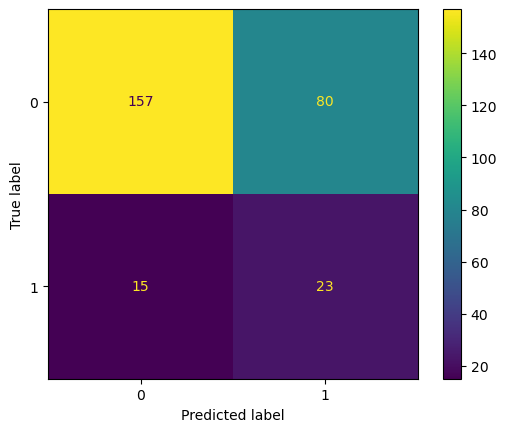

In [466]:
# Logistic regression

LogReg=LogisticRegression(class_weight='balanced',random_state=21,max_iter=1000).fit(X_train_selected,y_train)

#Predict the test set
y_pred_lr=LogReg.predict(X_test_selected)

#Confusion matrix
cm=confusion_matrix(y_test,y_pred_lr)
ConfusionMatrixDisplay(cm).plot()

I used the trained model to predict the unseen test set.

From the predicted values, I will calculate different accurcay metrics to compare model performance with other models.

In [470]:
# Accuracy metrics
acc_lr=accuracy_score(y_test,y_pred_lr)
recall_lr=recall_score(y_test,y_pred_lr)
precision_lr=precision_score(y_test,y_pred_lr)
f1_lr=f1_score(y_test,y_pred_lr)

print('Accuracy = '+"{:.3f}".format(acc_lr))
print('Recall = '+"{:.3f}".format(recall_lr))
print('Precision = '+"{:.3f}".format(precision_lr))
print('f1 = '+"{:.3f}".format(f1_lr))

Accuracy = 0.655
Recall = 0.605
Precision = 0.223
f1 = 0.326


Text(0.8, 0.3, 'AUC=0.634')

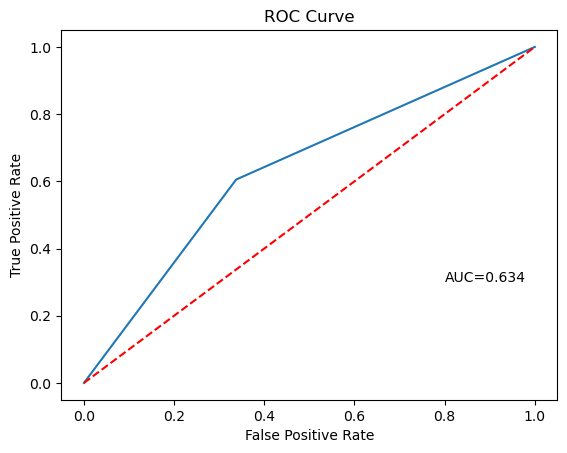

In [471]:
#ROC curve
fpr,tpr,th=roc_curve(y_test,y_pred_lr)
auc=roc_auc_score(y_test,y_pred_lr)
plt.plot(fpr,tpr,'-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.8,0.3,'AUC='+"{:.3f}".format(auc))

The Logistic Regression model performs not so well with an accuracy of 0.655. It misclassify a lot of living patients as deceased. 

However, the model performs better when it comes to classifying deceased patients. It has a recall of 0.605. 

This imbalance in precision and recall causes the f1 score to be low (0.326).


### Random Forest

I choose random forest classifier to model this data because of its robustness to outlier, resistance to overfitting, and fast running time.

To reduce overfitting of the model, I will perform 5 fold cross validation. This will help my model become more robust.

I will use GridSearch to tune the hyperparameter of the model. The hyperparameter max depth decides the maximun depth of each tree. I pick the possible value for max depth to be 2,3,4 so the model doesn't overfit. Another hyperparameter I'm tuning is number of trees in the model. This number range from 200 to 1000.

I pick f1 as the refit because I want to get the model with the highest balance of recall and precision.

In [530]:
#Random Forest
rf=RandomForestClassifier(class_weight='balanced_subsample',random_state=21)

#Cross validation fitting
cv_params = {'max_depth': [2,3,4], 
             'n_estimators': list(range(200,1001,100))}  

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')
rf_cv.fit(X_train_selected, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=21),
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [200, 300, 400, 500, 600, 700, 800,
                                          900, 1000]},
             refit='f1', scoring={'accuracy', 'precision', 'f1', 'recall'})

I'm plotting how the model f1 score changes after each iteration of the hyperparameter choice

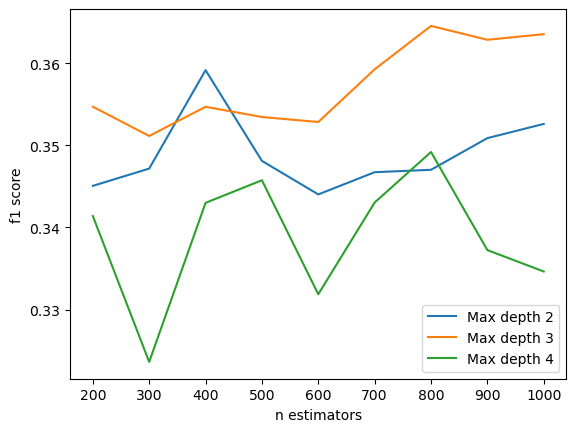

Best parameters based on f1 score: 
{'max_depth': 3, 'n_estimators': 800}


In [531]:
#Plot iteration
rf_cv_res=pd.DataFrame(rf_cv.cv_results_)

plt.plot(list(range(200,1001,100)), np.array(rf_cv_res[rf_cv_res.param_max_depth==2].mean_test_f1), label = "Max depth 2") 
plt.plot(list(range(200,1001,100)), np.array(rf_cv_res[rf_cv_res.param_max_depth==3].mean_test_f1), label = "Max depth 3") 
plt.plot(list(range(200,1001,100)), np.array(rf_cv_res[rf_cv_res.param_max_depth==4].mean_test_f1), label = "Max depth 4")
plt.legend()
plt.xlabel('n estimators') 
plt.ylabel('f1 score') 
plt.show()

print("Best parameters based on f1 score: ")
print(rf_cv.best_params_)

We can see that the best performing model based on f1 has max depth of 3 and 800 estimators. I will use this model for accuracy valuation of the test data.

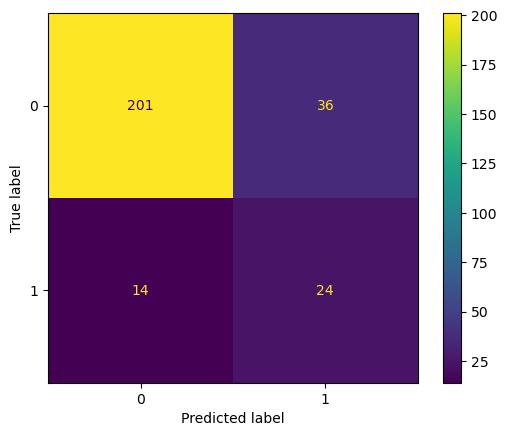

In [532]:
#Predict with test set
y_pred_rf=rf_cv.best_estimator_.predict(X_test_selected)

#Confusion matrix
cm=confusion_matrix(y_test,y_pred_rf)
ConfusionMatrixDisplay(cm).plot()

I used the best trained model to predict the unseen test set.

From the predicted values, I will calculate different accurcay metrics to compare model performance with other models.

In [535]:
# Accuracy metrics
acc_rf=accuracy_score(y_test,y_pred_rf)
recall_rf=recall_score(y_test,y_pred_rf)
precision_rf=precision_score(y_test,y_pred_rf)
f1_rf=f1_score(y_test,y_pred_rf)

print('Accuracy = '+"{:.3f}".format(acc_rf))
print('Recall = '+"{:.3f}".format(recall_rf))
print('Precision = '+"{:.3f}".format(precision_rf))
print('f1 = '+"{:.3f}".format(f1_rf))

Accuracy = 0.818
Recall = 0.632
Precision = 0.400
f1 = 0.490


Text(0.8, 0.3, 'AUC=0.740')

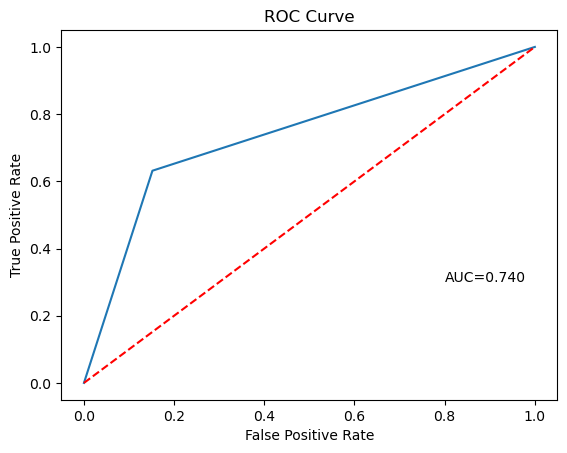

In [534]:
#ROC curve
fpr,tpr,th=roc_curve(y_test,y_pred_rf)
auc=roc_auc_score(y_test,y_pred_rf)
plt.plot(fpr,tpr,'-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.8,0.3,'AUC='+"{:.3f}".format(auc))

The Random Forest model model performs pretty well with an accuracy of 0.818. It does a good job at classifying deceased patients with a recall of 0.632. It also improves on the f1 score, suggesting a more balanced precision and recall.

The ROC curve looks better than the ROC curve of Logistic Regression. The AUC also improves


### Adaboost

I also fit the data with Adaboost model because this model can be highly efficient in binary classification.

To reduce overfitting of the model, I will perform 5 fold cross validation. This will help my model become more robust.

I will use GridSearch to tune the hyperparameter of the model. The hyperparameter learning rate has possible values of 0.1, 0.25, 0.5, 1. Another hyperparameter I'm tuning is number of trees in the model. This number range from 200 to 600.

I pick f1 as the refit because I want to get the model with the highest balance of recall and precision.

In [519]:
# Adaboost
ac=AdaBoostClassifier(random_state=21)

#Cross validation fitting
cv_params = {'learning_rate': [0.1,0.25,0.5,1], 
             'n_estimators': list(range(100,601,100))}  

scoring = {'accuracy', 'precision', 'recall', 'f1'}

ac_cv = GridSearchCV(ac, cv_params, scoring=scoring, cv=5, refit='f1')
ac_cv.fit(X_train_selected,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=21),
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 1],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             refit='f1', scoring={'accuracy', 'precision', 'f1', 'recall'})

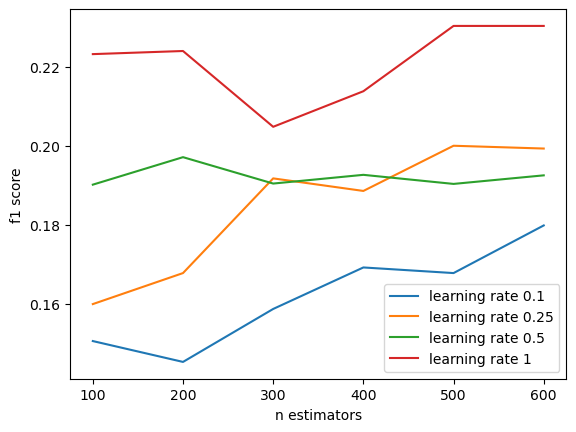

Best parameters based on f1 score: 
{'learning_rate': 1, 'n_estimators': 500}


In [520]:
#Plot iteration
ac_cv_res=pd.DataFrame(ac_cv.cv_results_)

plt.plot(list(range(100,601,100)), np.array(ac_cv_res[ac_cv_res.param_learning_rate==0.1].mean_test_f1), label = "learning rate 0.1") 
plt.plot(list(range(100,601,100)), np.array(ac_cv_res[ac_cv_res.param_learning_rate==0.25].mean_test_f1), label = "learning rate 0.25") 
plt.plot(list(range(100,601,100)), np.array(ac_cv_res[ac_cv_res.param_learning_rate==0.5].mean_test_f1), label = "learning rate 0.5")
plt.plot(list(range(100,601,100)), np.array(ac_cv_res[ac_cv_res.param_learning_rate==1].mean_test_f1), label = "learning rate 1")
plt.legend()
plt.xlabel('n estimators') 
plt.ylabel('f1 score') 
plt.show()

print("Best parameters based on f1 score: ")
print(ac_cv.best_params_)

We can see that the best performing model based on f1 has learning rate of 1 and 500 estimators. I will use this model for accuracy valuation of the test data.

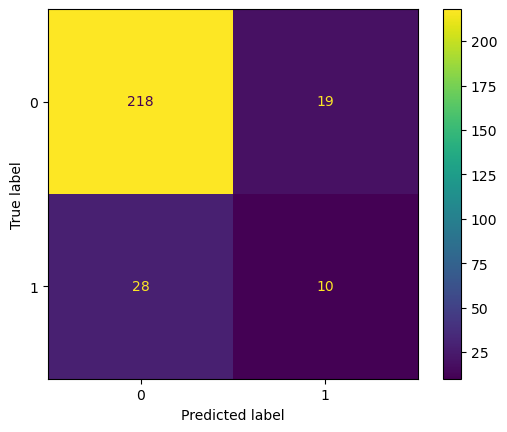

In [521]:
#Predict with test set
y_pred_ac=ac_cv.best_estimator_.predict(X_test_selected)

#Confusion matrix
cm=confusion_matrix(y_test,y_pred_ac)
ConfusionMatrixDisplay(cm).plot()

In [522]:
# Accuracy metrics
acc_ac=accuracy_score(y_test,y_pred_ac)
recall_ac=recall_score(y_test,y_pred_ac)
precision_ac=precision_score(y_test,y_pred_ac)
f1_ac=f1_score(y_test,y_pred_ac)

print('Accuracy = '+"{:.3f}".format(acc_ac))
print('Recall = '+"{:.3f}".format(recall_ac))
print('Precision = '+"{:.3f}".format(precision_ac))
print('f1 = '+"{:.3f}".format(f1_ac))

Accuracy = 0.829
Recall = 0.263
Precision = 0.345
f1 = 0.299


Text(0.8, 0.3, 'AUC=0.705')

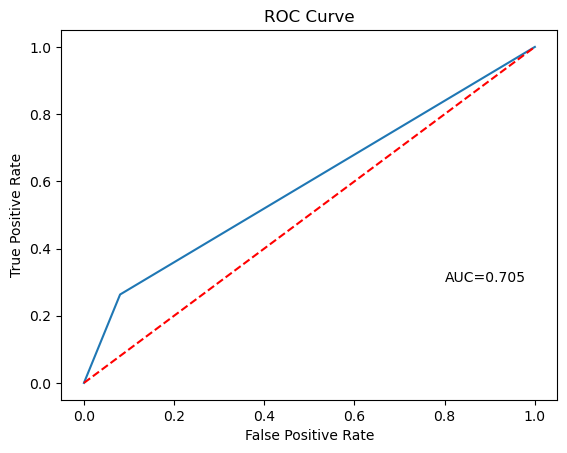

In [523]:
fpr,tpr,th=roc_curve(y_test,y_pred_ac)
auc=roc_auc_score(y_test,y_pred_rf)
plt.plot(fpr,tpr,'-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.8,0.3,'AUC='+"{:.3f}".format(auc))

The Random Forest model model performs pretty well with an accuracy of 0.829.It does a good job at classifying living patients correctly. 

However, the model performs poorly when classifying deceased patients with a recall of 0.263. This causes the f1 score to be low (0.299).


## Comparing models

I will compare the 3 models and select the best model for this classification problem

### Recall Score

In this problem, recall score is an important accuracy metrics to compare models. This is because the goal of this project is to identify high risk patients. It is crucial that the model can identify deceased patients correctly with a low false negative rate. 

Therefore, I will use recall as my main metric to compare the models.



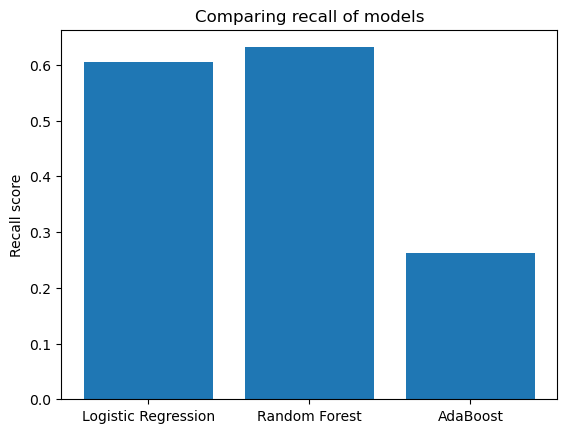

In [537]:
recalls = [recall_lr, recall_rf,recall_ac]

plt.bar(["Logistic Regression", "Random Forest","AdaBoost"], recalls, capsize=5)
plt.ylabel("Recall score")
plt.title("Comparing recall of models")
plt.show()

We can see that the recall of Random forest is highest. The recall of Logistic regression is slightly lower and the AdaBoost classifier has the lowest recall score. 

This suggests that Random Forest Classifier is the best performing model based on recall score. That indicates Random forest can identify patients at a high survival risk more accurately.

### F1 score

I will also compare the models based on their f1 score. f1 score shows the balance between precision and recall.

My data set is imbalanced in class, in which the number surving patients is much greater than the number of deceased patients. F1 Score will capture both precision and recall of the model to see if the model is affected by class imbalance.

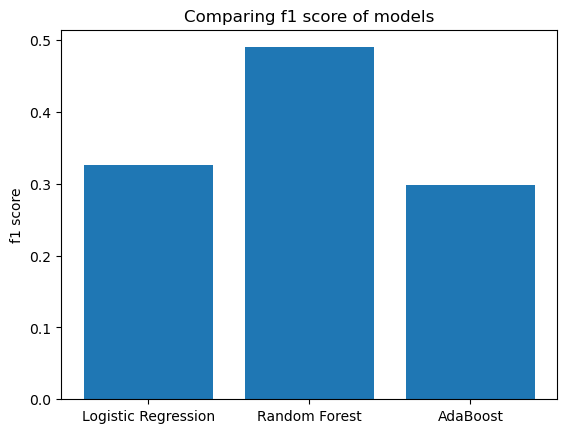

In [538]:
f1s = [f1_lr, f1_rf,f1_ac]

plt.bar(["Logistic Regression", "Random Forest","AdaBoost"], f1s, capsize=5)
plt.ylabel("f1 score")
plt.title("Comparing f1 score of models")
plt.show()

Comparing the f1 score, Random Forest seems to be the highest performing model. The f1 score of Logistic Regression is lower and AdaBoost has the lowest f1.

This suggests that there is most balance between precision and recall in the Random Forest model. 

Based on both f1 and recall, Random Forest is the highest performing models out of the 3 models.

## Discussion

- This project aims at solving a classification problem of breast cancer patient survival status. The features include patients' clinical information such as ER, PR status, tumor stage, metastasis, age and menopausal status. I have inpected and cleaned the data. After that, I selected the important features that predict patient survival status. I found some clinical features that are important to deciding patients survival: Age, Suvival months, Metastatis status, tumor stage, ER, PR status, and menopausal status.

- The data is fitted to 3 different classification models: Logistic Regression, Random Forest, and AdaBoost. Based on the f1 score and recall score, the Random Forest model is the best performing model with the ability to predict patients survival accurately. Random Forest works best with this data set because of its robustness and resistance to overfitting. Therefore, I selected Random Forest as my final model to predict patient survival.

- Even though Random Forest can predict the best out of the 3 models, the precision is still low: 0.4. I think this is caused by class imbalance in my data. My data has 945 living patients but only 152 deceased patients. This caused the model to spend most of its time learning about the living patients but don't have enough data on deceased patients. Therefore, class imbalance has made my model has a low precision.

- To resolve class imbalance, in future project, I can find new data on deceased patients and up sample my data set. I can also down sample and randomly reduce the number of living patients, so that the proportion of deceased patients to living patients is closer to 1. I believe that by either up sampling or dowin sampling the data, I can achieve a higher predictive accuracy with my model.